## Installing libraries

In [4]:
!pip install scikit-multilearn
!pip install contractions
# !pip install mlxtend

In [5]:
%pip install mlxtend --upgrade

In [6]:
import pandas as pd
import numpy as np
import re
import nltk.corpus
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords, words
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from mlxtend.evaluate import bias_variance_decomp

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing Dataset


In [7]:
test_label = pd.read_csv("test_labels.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [8]:
# Merging test and train to form one huge dataset
test_data = pd.merge(test, test_label)
dataset = pd.concat([test_data, train])
dataset.drop(columns=['id'], inplace=True)
dataset.drop_duplicates(inplace=True, ignore_index=True)
dataset.drop(dataset.index[dataset['toxic'] == -1], inplace = True)
dataset.reset_index(inplace = True)

## Feature Engineering 

In [9]:
# Comment length
dataset['length'] = dataset.comment_text.apply(lambda x: len(x))
    
# Capitalization percentage
def pct_caps(s):
  return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)

dataset['caps'] = dataset.comment_text.apply(lambda x: pct_caps(x))

# Mean Word length 
def word_length(s):
  s = s.split(' ')
  return np.mean([len(w) for w in s if w.isalpha()])

dataset['word_length'] = dataset.comment_text.apply(lambda x: word_length(x))

# Average number of exclamation points 
dataset['exclamation'] = dataset.comment_text.apply(lambda s: len([c for c in s if c == '!']))

# Average number of question marks 
dataset['question'] = dataset.comment_text.apply(lambda s: len([c for c in s if c == '?']))
    
# Normalize
for label in ['length', 'caps', 'word_length', 'question', 'exclamation']:
  minimum = dataset[label].min()
  diff = dataset[label].max() - minimum
  dataset[label] = dataset[label].apply(lambda x: (x-minimum) / (diff))

# Strip IP Addresses
ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
def strip_ip(s, ip):
  try:
    found = ip.search(s)
    return s.replace(found.group(), ' ')
  except:
    return s

dataset.comment_text = dataset.comment_text.apply(lambda x: strip_ip(x, ip))
    
dataset

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,index,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,caps,word_length,exclamation,question
0,5,Thank you for understanding. I think very high...,0,0,0,0,0,0,0.019004,0.025005,0.001995,0.000000,0.000000
1,7,:Dear god this site is horrible.,0,0,0,0,0,0,0.006201,0.038469,0.001496,0.000000,0.000000
2,11,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0.089418,0.041185,0.002353,0.000202,0.020492
3,13,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0.100020,0.103380,0.002147,0.000000,0.000000
4,14,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0.066613,0.015876,0.002328,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223544,312730,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0.058812,0.008774,0.002605,0.000000,0.008197
223545,312731,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0.019604,0.029857,0.001906,0.000000,0.000000
223546,312732,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0.016003,0.062513,0.003408,0.000000,0.000000
223547,312733,And it looks like it was actually you who put ...,0,0,0,0,0,0,0.023005,0.021744,0.001801,0.000000,0.000000


## Text cleaning

In [10]:
# Text cleaning
#converting to lower case
#dataset['comment_text_cleaned'] = dataset['comment_text'].str.lower()
#removing special characters
dataset['comment_text'] = dataset['comment_text'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", str(elem)))
#removing numbers
dataset['comment_text'] = dataset['comment_text'].apply(lambda elem: re.sub(r"\d+", "", str(elem)))
# Removing stop words
stop = stopwords.words('english')
dataset['comment_text'] = dataset['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# Replacing contractions with their full forms
dataset['comment_text'] = dataset['comment_text'].apply(lambda x: contractions.fix(x))
#Tokenizing
dataset['comment_text'] = dataset['comment_text'].apply(lambda x: word_tokenize(x))
#Lemmitization
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
dataset['comment_text'] = dataset['comment_text'].apply(lambda x: word_lemmatizer(x))

In [11]:
# Splitting into train test sets
X = dataset.drop(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
y = dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()

X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X,y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val,y_test_and_val, train_size=0.5)

In [12]:
#dd = X_train.loc[dataset['severe_toxic'] == 1]
#X_train= pd.concat([dataset, dd])
#dd= X_train.loc[dataset['threat'] == 1]
#X_train= pd.concat([dataset, dd])
#dd= X_train.loc[dataset['identity_hate'] == 1]
#X_train= pd.concat([dataset, dd])

In [13]:
train_tokens = pd.Series(X_train['comment_text']).values
w2v_model = Word2Vec(train_tokens, size= 200)

def buildWordVector(tokens, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0.
  for word in tokens:
    try:
      vec += w2v_model[word].reshape((1, size))
      count += 1.
    except KeyError:
      continue
  if count != 0:
    vec /= count
  return vec

In [14]:
train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in train_tokens])
# train_vecs_w2v = scaler.fit_transform(train_vecs_w2v)
train_vecs_w2v = scale(train_vecs_w2v)

val_tokens = pd.Series(X_val['comment_text']).values
val_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in val_tokens])
# val_vecs_w2v = scaler.transform(val_vecs_w2v)
val_vecs_w2v = scale(val_vecs_w2v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [15]:
train_vecs_w2v.shape

(178839, 200)

In [16]:
X_train

,index,comment_text,length,caps,word_length,exclamation,question
164866,254052,"[The, National, Champions, banner, season, rec...",0.213643,0.034098,0.002612,0.000000,0.000000
190495,279681,"[Yeah, probably, something, like, business, in...",0.042208,0.017345,0.002752,0.000000,0.000000
192094,281280,"[They, look, like, THE, BEATLES, beatles, NOT,...",0.048210,0.148966,0.001845,0.000405,0.000000
212036,301222,"[HyperVM, insecure, system, Sure, us, SSL, nee...",0.044809,0.079112,0.002087,0.000000,0.000000
37438,89556,"[Vandal, rollback, twin, Hi, Can, explain, edi...",0.053611,0.040825,0.002297,0.000000,0.004098
...,...,...,...,...,...,...,...
5374,12963,"[Oppose, per, CONSORTS, comment]",0.008002,0.300060,0.002394,0.000000,0.000000
192172,281358,"[Holophonor, Seems, kind, strange, kid, holoph...",0.035407,0.028991,0.002208,0.000000,0.000000
214720,303906,"[Do, use, I, agree, template, used, eventually...",0.038608,0.032474,0.002145,0.000000,0.000000
36392,87137,"[From, Sukanta, Do, Not, mi, guide, reader, It...",0.251050,0.027728,0.002337,0.000405,0.004098


In [17]:
train_df = pd.DataFrame(train_vecs_w2v)
X_train = X_train.reset_index()
# train_df=X_train
# train_df=train_df.drop(columns=['index','comment_text'])
train_df['length']= X_train['length']
train_df['caps']=X_train['caps']
train_df['word_length']= X_train['word_length']
train_df['exclamation']=X_train['exclamation']
train_df['question']=X_train['question']
train_df= train_df.fillna(0)
train_df

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,length,caps,word_length,exclamation,question
0,0.409968,-0.115849,-0.640699,0.595828,-0.467485,0.033629,1.393978,-1.053759,-0.604440,-0.769896,...,0.205147,-0.795094,0.078372,-0.028063,-0.070600,0.213643,0.034098,0.002612,0.000000,0.000000
1,0.617049,0.074351,0.139012,-0.350361,0.753244,-0.158072,-1.600388,0.964218,-0.319864,-0.134554,...,0.249404,0.187878,0.584907,-0.504969,0.397271,0.042208,0.017345,0.002752,0.000000,0.000000
2,-0.453637,-0.141533,0.660432,1.558286,0.091960,-0.365815,0.336737,1.488815,-0.969601,-2.064750,...,0.398895,0.183727,-1.530925,-1.480353,-1.499244,0.048210,0.148966,0.001845,0.000405,0.000000
3,-0.402912,0.292399,-0.853933,0.547068,-0.114131,0.308231,-0.505021,-0.015469,0.495050,-0.869424,...,0.239949,-0.404097,-0.264258,-0.209474,-0.239751,0.044809,0.079112,0.002087,0.000000,0.000000
4,-0.143978,-0.654466,-0.196933,-0.972426,0.347488,0.260655,-0.702548,-0.126531,-0.309010,0.833151,...,0.617993,-0.430787,0.273959,0.220333,0.673665,0.053611,0.040825,0.002297,0.000000,0.004098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178834,0.748851,2.056122,-0.289098,-1.549879,1.807581,0.232836,-0.369916,-2.462169,-2.179440,1.244608,...,1.608093,-2.026977,-2.820279,2.417743,-1.392524,0.008002,0.300060,0.002394,0.000000,0.000000
178835,-1.334874,-0.108829,1.822244,1.137749,-0.770211,0.205343,-0.046668,0.493309,-0.724791,-1.245579,...,0.329612,-0.304872,0.493868,0.042998,-1.418336,0.035407,0.028991,0.002208,0.000000,0.000000
178836,-0.317474,-0.018055,-0.563503,0.360604,1.013070,1.231636,-0.498403,-0.386235,0.974043,0.747761,...,-0.717698,-0.809805,-0.611005,-0.220038,-0.282526,0.038608,0.032474,0.002145,0.000000,0.000000
178837,-0.133450,-0.657232,-0.154119,-0.271441,0.580188,0.238362,0.028307,-0.014278,0.573838,-0.228265,...,0.202183,-0.523589,0.089494,0.239443,-0.073220,0.251050,0.027728,0.002337,0.000405,0.004098


In [18]:
val_df = pd.DataFrame(val_vecs_w2v)
# val_df=X_val
# val_df=val_df.drop(columns=['index','comment_text'])
X_val = X_val.reset_index()

val_df['length']= X_val['length']
val_df['caps']=X_val['caps']
val_df['word_length']= X_val['word_length']
val_df['exclamation']=X_val['exclamation']
val_df['question']=X_val['question']
val_df= val_df.fillna(0)

val_df

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,length,caps,word_length,exclamation,question
0,0.250495,0.054285,0.177638,-0.348957,-1.051837,0.159725,1.028733,-0.436509,-1.779125,-1.255142,...,-0.394637,-0.316954,-1.127805,0.909510,-0.201748,0.013403,0.069782,0.005320,0.000000,0.000000
1,-0.272828,0.292433,-0.021680,0.896274,-0.363075,0.453659,0.118461,-0.480546,-0.264750,-0.304868,...,0.339059,-0.379959,-0.207104,-0.632122,-0.099374,0.745149,0.063277,0.002155,0.000202,0.045082
2,0.195196,0.016256,0.321757,-0.891833,0.824139,-0.189260,-0.070369,0.635495,0.547896,-0.517974,...,-0.625441,-0.511425,0.292458,0.744526,-0.138209,0.280856,0.057471,0.002123,0.000000,0.000000
3,0.094972,0.225653,0.735419,-0.098179,1.045070,0.650201,0.302440,-0.447037,0.986660,-0.302740,...,0.639456,-0.807825,0.806336,0.380580,-0.547720,0.101820,0.058522,0.002122,0.000000,0.000000
4,0.130074,-0.111924,-0.318822,0.093708,1.375044,0.973701,0.574993,-1.975134,0.467883,-0.186733,...,1.559383,-0.936101,0.191631,-0.369315,0.185241,0.092619,0.024134,0.002119,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22350,-0.663269,-0.739162,0.398016,-0.653355,1.187712,0.618210,0.294776,0.526474,1.186519,-0.460671,...,-0.449177,-1.412304,1.385050,1.056273,-0.459686,0.048810,0.027939,0.001762,0.000000,0.000000
22351,-0.865418,0.474704,-0.181917,0.214467,0.829603,0.511151,-0.742840,0.973032,0.918125,0.416523,...,0.596045,-0.941002,0.274231,0.590699,-0.469216,0.065613,0.015813,0.001930,0.000000,0.000000
22352,-0.357969,0.032722,-0.365814,0.959480,-0.692732,0.396859,1.214456,-0.689434,-0.838111,-0.373925,...,0.408388,-0.054047,-0.739860,-0.140111,-0.716201,0.802160,0.046008,0.002530,0.000000,0.000000
22353,-1.290517,-0.864014,1.463891,0.494637,0.255604,-1.058402,-1.231766,3.142018,-0.983072,-2.449609,...,0.309306,0.738318,-0.044050,1.000491,-0.002655,0.004001,0.000000,0.003325,0.000000,0.000000


## Neural NETWORK

In [19]:
model = Sequential()
model.add(Dense(160, input_dim = train_df.shape[1], activation='sigmoid', kernel_initializer='he_uniform'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',)
model.fit(train_df, y_train, epochs=100, verbose=0) #epochs=100

In [20]:
predictions = model.predict(val_df)
predictions = predictions.round()
predictions

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0.]], dtype=float32)

In [22]:
import pickle as pk
pk.dump(model, open('tuned_neural_network_model.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://ab43f33b-6236-4091-a4ec-13a0d9395ba0/assets


## Evaluation

In [33]:
def score(y_true, y_pred, label):
  prec = precision_score(y_true, y_pred,average='micro')
  re = recall_score(y_true, y_pred,average='micro')
  print('Results for label:', label)
  print('Precision score:', prec)
  print('Recall score:', re)
  print('Final Score:', re*0.6 + prec*0.4, '\n')
  return re*0.6 + prec*0.4

In [35]:
val_score = score(y_val, predictions,'Neural Network with Word2Vec')

Results for label: Neural Network with Word2Vec
Precision score: 0.620353982300885
Recall score: 0.5713121434392828
Final Score: 0.5909288789839237 



In [34]:
#Variance
predictions1 = model.predict(train_df)
predictions1 = predictions1.round()

train_Score = score(y_train, predictions1,'Neural Network with Word2Vec')
print("The variance for neural network is:")
print(train_Score-val_score)

Results for label: Neural Network with Word2Vec
Precision score: 0.8871938980329185
Recall score: 0.8307646041651003
Final Score: 0.8533363217122276 

The variance for neural network is:
[0.26240744 0.23298234 0.28202418]


Model: Tuned NN with 
Feature extraction method: Word2Vec 

Results for label: toxic
Precision score: 0.9334824424066205
Recall score: 0.9334824424066205
Final Score: 0.9334824424066206 

Results for label: severe_toxic
Precision score: 0.990874524714829
Recall score: 0.990874524714829
Final Score: 0.990874524714829 

Results for label: obscene
Precision score: 0.9614403936479535
Recall score: 0.9614403936479535
Final Score: 0.9614403936479536 

Results for label: threat
Precision score: 0.9966450458510401
Recall score: 0.9966450458510401
Final Score: 0.9966450458510401 

Results for label: insult
Precision score: 0.956922388727354
Recall score: 0.956922388727354
Final Score: 0.9569223887273541 

Results for label: identity_hate
Precision score: 0.9897562066651756
Recall score: 0.9897562066651756
Final Score: 0.9897562066651755 



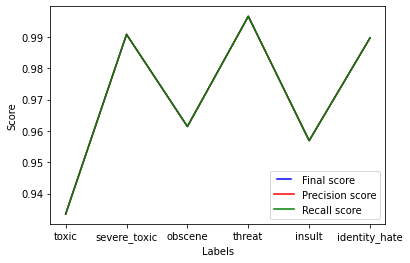

In [25]:
predictions = pd.DataFrame({'toxic': predictions[:, 0], 'severe_toxic': predictions[:, 1], 'obscene': predictions[:, 2], 'threat': predictions[:, 3], 'insult': predictions[:, 4], 'identity_hate': predictions[:, 5]})

print('Model: Tuned NN with \nFeature extraction method: Word2Vec ')
print()
prec_score = []
re_score = []
fina_score = []
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for label in labels:
  scores = score(y_val[label], predictions[label], label)
  fina_score.append(scores[0])
  prec_score.append(scores[1])
  re_score.append(scores[2])

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(labels, fina_score, 'b', label='Final score')
line2, = plt.plot(labels, prec_score, 'r', label='Precision score')
line3, = plt.plot(labels, re_score, 'g', label='Recall score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('Labels')
plt.show()